# Chapter 10. Introduction to Artificial Neural Networks with Keras

In [6]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

np.random.seed(0)

plt.style.use('seaborn-whitegrid')

In [7]:
%matplotlib inline

In [8]:
%load_ext ipycache

The ipycache extension is already loaded. To reload it, use:
  %reload_ext ipycache


## From biological to artificial neurons

The author briefly described the origins of the field of artificial neural networks (ANN) and how real neurons work; I will skip recounting that section here.

### Logical computations with neurons

The first artificial neuron was proposed as a function with one or more binary inputs and one binary output.
The output is activated when a certain number of inputs are activated.
Several of these neurons working together can reproduce standard logic gates.

### The Perceptron

The *perceptron* was invented in 1957 by Frank Rosenblatt.
It is *threshold logic unit* (TLU) (or a *linear threshold unit*, LTU).
Each input and the  output are numeric values (not binary) and each input has an associated weight.
The TLU computes the weighted sum of the inputs ($z = w_1 x_1 + w_2 x_2 + ... + w_n x_n = \textbf{x}^T \textbf{w}$) and applies a step function to the result to decide the output ($h_w(\textbf{x}) = \text{step}(z)$).
The most common step functions were the *Heaviside step function* and the *sign function*:

$$
\text{heaviside} (z) =
\begin{cases}
    0 \text{ if } z  <  0 \\ 
    1 \text{ if } z \ge 0 \\
\end{cases}
$$

$$
\text{sgn}(z) =
\begin{cases}
    -1 \text{if } z < 0 \\ 
    0  \text{if } z = 0 \\
    1  \text{if } z > 0 \\
\end{cases}
$$

A single TLU can be used for linear classification.
Training the TLU means finding the values for the weights ($w_1, w_2, ..., w_n = \textbf{w}$)

A perceptron is a single layer of TLUs with each TLU connected to all of the input neurons (creating a *fully connected layer*).
The input neurons are just simple passthrough functions where the output equals the input.
An extra *bias neuron* is usually added that always has the value 1 and is connected to each neuron; this helps with the linear algebra for calculating the output of the perceptron:

$$
h_{\textbf{W}, \textbf{b}} = \phi(\textbf{XW} + \textbf{b}) \\
$$

$$
\text{where }
\begin{cases}
    \textbf{X}: \text{represents the matrix of input features; one row per instance, one column per feature} \\
    \textbf{W}: \text{represents the weight matrix from the input neurons to the TLU neurons} \\
    \textbf{b}: \text{represents the weight vector from the bias neurons to the TLU neurons} \\
    \phi: \text{represents the activation function; the step function for TLUs} \\
\end{cases}
$$

The perceptron is trained using *Hebb's Rule*: the connection weight between two neurons tends to increase when they fire simultaneously.
The algorithm also accounts for the accuracy of the prediction; for each training instance, the weights are updated with the following *Perceptron learning rule*:

$$
w_{i,j}^{\text{next step}} = w_{i,j} + \eta (y_j - \hat{y_j}) x_i
$$

$$
\text{where }
\begin{cases}
    w_{i,j}: \text{the connection weight between the } i^{th} \text{ input neuron and } j^{th} \text{output neuron} \\
    x_i: \text{the } i^{th} \text{ input value of the training instance} \\
    \hat{y_j}: \text{the output of the } j^{th} \text{ output neuron for the training instance} \\
    y_j: \text{the target output of the } j^{th} \text{ output neuron for the training instance} \\
    \eta: \text{the learning rate} \\
\end{cases}
$$

The decision boundary for each output neuron is linear, so perceptrons are only capable of linear separation.
Though, when this is possible for the data, the perceptron will converge.

There are some critical limitations to a perceptron, notably that it cannot learn XOR logic, but many of these can be overcome by using multiple layers to create a *Multilayer Perceptron* (MLP).

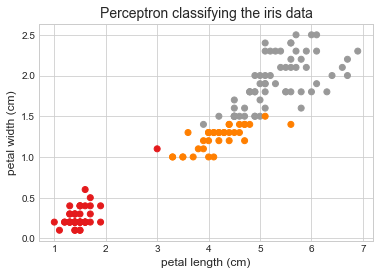

In [9]:
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

# Load the iris data and only use petal length and width (cm.).
iris = load_iris()
X = iris.data[:, (2, 3)]
y = iris.target

# Train a perceptron.
per_clf = Perceptron()
per_clf.fit(X, y)

# Plot the prediction results.
plt.scatter(X[:, 0], X[:, 1], c=per_clf.predict(X), cmap='Set1')
plt.title('Perceptron classifying the iris data', fontsize=14)
plt.xlabel(iris.feature_names[2], fontsize=12)
plt.ylabel(iris.feature_names[3], fontsize=12)
plt.show()

## The multilayer perceptron (MLP) and backpropagation

An MLP has one *input layer* built of passthrough neurons, one or more *hidden layers* of TLUs, and one *ouput layer* of TLUs. 
The layers near the input are called *lower layers* whereas the layers near the output are *upper layers*.
When an ANN contains a deep stack of hidden layers, it is called a *deep neural network* (DNN).

*Backpropagation* makes training a MLP possible.
It is able to compute the gradient of the nwtwork's error with regard to every single model parameter.
Therefore, the connection weights and bias terms can be tweaked optimally to reduce error.
Once the gradient is found, normal gradient descent can be followed.
Below is the most basic interpretation of the algorithm:

1. A mini-batch is fed into the input layers.
2. The data progresses through the layers and the results of each layer are remembered. This is the *forward pass*.
3. A final output is calculated and a loss function is used to determine the error.
4. The chain rule is used to measure how much each output connected contributed to the error.
5. The error is *backpropagated* using the chain rule to measure how much of the error came from each connection in the network.
6. The error gradient is used to compute the optimal adjustments for each connection weight.

In order to compute the derivative of each neuron, the step function had to be replaced.
Currently, it is common to use the logistic equation, hyperbolic tangent function, or rectified linear unit (ReLU):

$$
\begin{aligned}
\text{logistic: }& \quad \sigma(z) = 1 / (1 + e^{-z}) \\
\text{hyperbolic tangent: }& \quad \tanh(z) = 2 \sigma(2z) - 1 \\
\text{ReLU: }& \quad \text{ReLU}(z) = \max(0, z) \\
\end{aligned}
$$

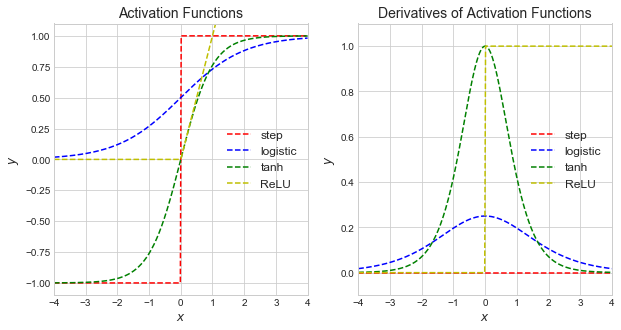

In [10]:
# Input points
x = np.linspace(-4, 4, 300)

# Neruon activation functions.

def step_fxn(x):
    """Step function for neuron activation function."""
    return [-1 if i < 0 else 1 for i in x]


def step_fxn_d(x):
    """Derivative of the step function."""
    return np.zeros(len(x))


def logistic_fxn(x):
    """Logisitc (sigmoid) function for neuron activation function."""
    return 1 / (1 + np.exp(-x))


def logistic_fxn_d(x):
    """The derivative of the logistic function."""
    return logistic_fxn(x) * (1 - logistic_fxn(x))


def hyperbolic_tan(x):
    """Hyperbolic tangent function for neuron activation function."""
    return 2 * logistic_fxn(2 * np.array(x)) - 1


def hyperbolic_tan_d(x):
    """The derivative of the hyperbolic tangent function."""
    return 1 - (np.tanh(x) ** 2)


def relu_fxn(x):
    """The ReLU for a neuron activation function."""
    return [max(0, i) for i in x]


def relu_fxn_d(x):
    """The derivative of the ReLU"""
    return [0 if i < 0 else 1 for i in x]


# Styles of line.
line_styles = {
    'step': 'r--',
    'logistic': 'b--',
    'tanh': 'g--',
    'relu': 'y--'
}

# Plotting each activation function.
fig = plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x, step_fxn(x), line_styles['step'], label='step')
plt.plot(x, logistic_fxn(x), line_styles['logistic'], label='logistic')
plt.plot(x, hyperbolic_tan(x), line_styles['tanh'], label='tanh')
plt.plot(x, relu_fxn(x), line_styles['relu'], label='ReLU')
plt.axis([-4, 4, -1.1, 1.1])
plt.legend(loc='center right', fontsize=12)
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$y$', fontsize=12)
plt.title('Activation Functions', fontsize=14)

# Plotting the derivatives of the activation function.
plt.subplot(1, 2, 2)
plt.plot(x, step_fxn_d(x), line_styles['step'], label='step')
plt.plot(x, logistic_fxn_d(x), line_styles['logistic'], label='logistic')
plt.plot(x, hyperbolic_tan_d(x), line_styles['tanh'], label='tanh')
plt.plot(x, relu_fxn_d(x), line_styles['relu'], label='ReLU')
plt.axis([-4, 4, -0.1, 1.1])
plt.legend(loc='center right', fontsize=12)
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$y$', fontsize=12)
plt.title('Derivatives of Activation Functions', fontsize=14)

plt.show()

### Regression MLP

For a regression MLP, there must be one output neuron per output variable.
The neuron's activation function must be chosen depending on any constraints on the output (e.g. always positive, between 0 and 1) and no activation function can be used to leave the output value unconstrained.
The loss function most  commonly used in the MSE, though the mean absolute error (MAE) or Huber loss (a mixture of MSE and MAE) can be used if the training data has a lot of outliers.

### Classification MLP

If the decision is a binary classification, then only one neuron is required with a logistic activation function.
If there are multiple decisions, but each is binary, then there must be a neuron per decision, each with a logistic activation function.
If there is a single decision, but multiple possibilities (i.e. the image of 1 of 10 digits), then there must be an output neuron for each option with a *softmax function* across the whole output layer.
The softmax function ensures that each neuron is between 0 and 1 (inclusive) and that they sum to 1.
The loss function is usually the cross-entropy loss function.

---

>**Before moving on to using Keras to build ANNs, I followed the advice of the author and skipped to Exercise 1 for the chapter which was to experiment in the [TensorFlow Playground](https://playground.tensorflow.org/).**

---